### Notebook to explore how doubling the across-shore distance of the domain impacts eddies.
The U3HC4 tracer advection scheme is used because of the spurious water formation (35 g/kg) close to the offshore boundary. This notebook:
> - Determines the proper indexing for the across-shelf position. 
> > - In other words, align the grids for analysis
> - Computes probability density functions of each isohaline from s = [29,35]

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta
import time

import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot as plt, patches

In [2]:
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

paths = ['/d2/home/dylan/idealized_nummix/shelf_u3hc4_uwind_zerop1_dt_30_60d_avg.nc', #Normal domain 
         '/d2/home/dylan/idealized_nummix/shelf_u3hc4_uwind_zerop1_dt_30_across2x_50d_avg.nc'] #Doubled across-shore distance

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    ds1 = ds1.isel(ocean_time = slice(0,700)) #576 for 23 days
    return ds1, grid1

ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)
    # print('iter complete')
    
print('Time at last timestep', ds[0].ocean_time[-1].values)
print('Time at last timestep', ds[1].ocean_time[-1].values)

Time at last timestep 0001-01-30 03:30:00
Time at last timestep 0001-01-30 03:30:00


### Print the datasets so we can broadly check things look ok

In [3]:
ds[0]

<xarray.Dataset>
Dimensions:         (tracer: 5, s_rho: 30, s_w: 31, Nuser: 25, eta_rho: 194, xi_rho: 194, xi_u: 193, eta_v: 193, ocean_time: 700)
Coordinates: (12/29)
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    x_rho           (eta_rho, xi_rho) float64 dask.array<chunksize=(194, 194), meta=np.ndarray>
    y_rho           (eta_rho, xi_rho) float64 dask.array<chunksize=(194, 194), meta=np.ndarray>
    x_u             (eta_rho, xi_u) float64 dask.array<chunksize=(194, 193), meta=np.ndarray>
    y_u             (eta_rho, xi_u) float64 dask.array<chunksize=(194, 193), meta=np.ndarray>
    ...              ...
    z_rho_v0        (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(30, 193, 194), meta=np.ndarray>
    z_rho_psi0      (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(30, 193, 193), meta=np.ndarray>
    z_w0            (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 194, 194), meta=np.ndarray>
    z_w_u0          (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(31, 194, 193), meta=np.ndarray>
    z_w_v0          (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(31, 193, 194), meta=np.ndarray>
    z_w_psi0        (s_w, eta_v, xi_u) float64 dask.array<chunksize=(31, 193, 193), meta=np.ndarray>
Dimensions without coordinates: tracer, Nuser
Data variables: (12/149)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          object ...
    nHIS            int32 ...
    ...              ...
    dV_u            (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 194, 193), meta=np.ndarray>
    dV_w_u          (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 194, 193), meta=np.ndarray>
    dV_v            (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 193, 194), meta=np.ndarray>
    dV_w_v          (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 193, 194), meta=np.ndarray>
    dV_psi          (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 30, 193, 193), meta=np.ndarray>
    dV_w_psi        (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 1, 193, 193), meta=np.ndarray>
Attributes: (12/29)
    file:              shelf_dx_500_u3hc4_uwind_zerop1_dt_30_60d/shelf_u3hc4_...
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             SHELFSTRAT
    var_info:          /scratch/user/dylan.schlichting/COAWST/ROMS/External/v...
    ...                ...
    compiler_command:  /sw/eb/sw/impi/2019.9.304-iccifort-2020.4.304/intel64/...
    compiler_flags:    -fp-model precise -ip -O3 -traceback
    tiling:            016x004
    history:           ROMS/TOMS, Version 3.9, Friday - September 22, 2023 - ...
    ana_file:          /scratch/user/dylan.schlichting/COAWST/Projects/shelfs...
    CPP_options:       SHELFSTRAT, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_FS...

In [4]:
ds[1]

<xarray.Dataset>
Dimensions:         (tracer: 5, s_rho: 30, s_w: 31, Nuser: 25, eta_rho: 389, xi_rho: 194, xi_u: 193, eta_v: 388, ocean_time: 700)
Coordinates: (12/29)
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    x_rho           (eta_rho, xi_rho) float64 dask.array<chunksize=(389, 194), meta=np.ndarray>
    y_rho           (eta_rho, xi_rho) float64 dask.array<chunksize=(389, 194), meta=np.ndarray>
    x_u             (eta_rho, xi_u) float64 dask.array<chunksize=(389, 193), meta=np.ndarray>
    y_u             (eta_rho, xi_u) float64 dask.array<chunksize=(389, 193), meta=np.ndarray>
    ...              ...
    z_rho_v0        (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(30, 388, 194), meta=np.ndarray>
    z_rho_psi0      (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(30, 388, 193), meta=np.ndarray>
    z_w0            (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 389, 194), meta=np.ndarray>
    z_w_u0          (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(31, 389, 193), meta=np.ndarray>
    z_w_v0          (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(31, 388, 194), meta=np.ndarray>
    z_w_psi0        (s_w, eta_v, xi_u) float64 dask.array<chunksize=(31, 388, 193), meta=np.ndarray>
Dimensions without coordinates: tracer, Nuser
Data variables: (12/134)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          object ...
    nHIS            int32 ...
    ...              ...
    dV_u            (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 389, 193), meta=np.ndarray>
    dV_w_u          (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 389, 193), meta=np.ndarray>
    dV_v            (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 388, 194), meta=np.ndarray>
    dV_w_v          (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 388, 194), meta=np.ndarray>
    dV_psi          (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 30, 388, 193), meta=np.ndarray>
    dV_w_psi        (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 1, 388, 193), meta=np.ndarray>
Attributes: (12/29)
    file:              shelf_u3hc4_uwind_zerop1_dt_30_across2x_50d_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             SHELFSTRAT
    var_info:          /scratch/user/dylan.schlichting/COAWST/ROMS/External/v...
    ...                ...
    compiler_command:  /sw/eb/sw/impi/2019.9.304-iccifort-2020.4.304/intel64/...
    compiler_flags:    -fp-model precise -ip -O3 -traceback
    tiling:            024x003
    history:           ROMS/TOMS, Version 3.9, Tuesday - October 10, 2023 -  ...
    ana_file:          /scratch/user/dylan.schlichting/COAWST/Projects/shelfs...
    CPP_options:       SHELFSTRAT, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_FS...

In [5]:
print('Across-shore distance [km], normal shelf case: ', ds[0].dy[:,0].sum().values/1000)
print('Across-shore distance [km], 2x shelf case: ', ds[1].dy[:,0].sum().values/1000)

Across-shore distance [km], normal shelf case:  97.0
Across-shore distance [km], 2x shelf case:  194.5


### Create a timevector for labeling plots 

In [6]:
hours = np.arange(720)
h_day = np.arange(24)
hours_since0 = np.tile(h_day, 30)
timevec_days = np.trunc(np.arange(0,24*30)/24)

### Make a snapshot of the isohalines, then save to an animation for 30 days 

Text(0.5, 0.98, 'Time = Day 20 Hour 20')

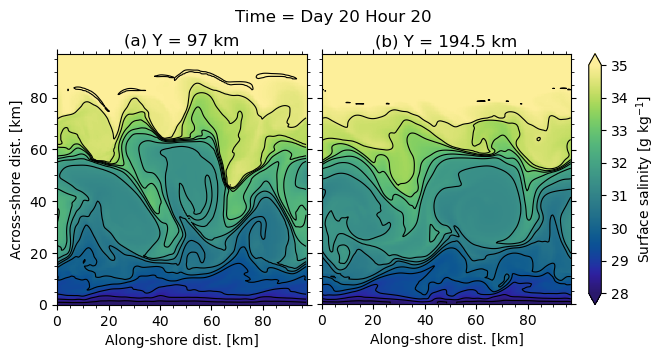

In [7]:
nrows = 1; ncols = 2
t = 500
fig, ax = plt.subplots(nrows,ncols, 
                       figsize = ((7/2)*1.87,(8.66/2.5)), 
                       constrained_layout = True, sharex = True)

cm = cmo.haline
cs = ax[0].pcolormesh(ds[0].x_rho/1000,ds[0].y_rho/1000, ds[0].salt[t,-1], 
                      vmin = 28, vmax = 35, cmap = cm)
cc = ax[0].contour(ds[0].x_rho/1000,ds[0].y_rho/1000, ds[0].salt[t,-1], 
              levels = np.arange(28,36,0.5), colors = 'k', linewidths = 0.8,
              add_colorbar = False)

cs = ax[1].pcolormesh(ds[1].x_rho/1000,ds[1].y_rho/1000, ds[1].salt[t,-1], 
                      vmin = 28, vmax = 35, cmap = cm)

ax[1].contour(ds[1].x_rho/1000,ds[1].y_rho/1000, ds[1].salt[t,-1], 
              levels = np.arange(28,35.5,0.5), colors = 'k', linewidths = 0.8,
              add_colorbar = False)

for j in range(ncols):
    ax[j].set_ylim(0,97)
    ax[j].set_yticks(np.arange(0,100,20))
    ax[j].set_xticks(np.arange(0,100,20))
    ax[j].minorticks_on()
    ax[j].set_xlabel('Along-shore dist. [km]')
    ax[j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    ax[i].set_aspect('equal') # Set aspect to equal since the domain is square


# for i in range(ncols-1):
ax[-1].set_yticklabels('')
ax[0].set_yticks([0,20,40,60,80])
ax[0].set_yticklabels(['0','20','40','60','80'])
    
for i in range(nrows):
    ax[i].set_ylabel('Across-shore dist. [km]')
    
ax[0].set_title('(a) Y = 97 km')
ax[1].set_title('(b) Y = 194.5 km')
fig.colorbar(cs, ax = ax[-1], label = r'Surface salinity [g kg$^{-1}$]', extend = 'both')
fig.suptitle('Time = '+ 'Day ' + str(int(timevec_days[t])) + ' Hour ' + str(hours_since0[t]))

# path = '/d2/home/dylan/idealized_nummix/diurnal_wind/boundary_tests/ani_frames/u3hc4_boundary_zerop1_hour_'+ str(int(hours[t]))+'.jpg'
# plt.savefig(path, dpi = 400, bbox_inches='tight')
# plt.clf()

In [8]:
# for t in range(len(ds[0].ocean_time)):
#     fig, ax = plt.subplots(nrows,ncols, 
#                            figsize = ((7/2)*1.87,(8.66/2.5)), 
#                            constrained_layout = True, sharex = True)

#     cm = cmo.haline
#     cs = ax[0].pcolormesh(ds[0].x_rho/1000,ds[0].y_rho/1000, ds[0].salt[t,-1], 
#                           vmin = 28, vmax = 35, cmap = cm)
#     cc = ax[0].contour(ds[0].x_rho/1000,ds[0].y_rho/1000, ds[0].salt[t,-1], 
#                   levels = np.arange(28,36,0.5), colors = 'k', linewidths = 0.8,
#                   add_colorbar = False)

#     cs = ax[1].pcolormesh(ds[1].x_rho/1000,ds[1].y_rho/1000, ds[1].salt[t,-1], 
#                           vmin = 28, vmax = 35, cmap = cm)

#     ax[1].contour(ds[1].x_rho/1000,ds[1].y_rho/1000, ds[1].salt[t,-1], 
#                   levels = np.arange(28,35.5,0.5), colors = 'k', linewidths = 0.8,
#                   add_colorbar = False)

#     for j in range(ncols):
#         ax[j].set_ylim(0,97)
#         ax[j].set_yticks(np.arange(0,100,20))
#         ax[j].set_xticks(np.arange(0,100,20))
#         ax[j].minorticks_on()
#         ax[j].set_xlabel('Along-shore dist. [km]')
#         ax[j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
#         ax[j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
#         ax[i].set_aspect('equal') # Set aspect to equal since the domain is square


#     # for i in range(ncols-1):
#     ax[-1].set_yticklabels('')
#     ax[0].set_yticks([0,20,40,60,80])
#     ax[0].set_yticklabels(['0','20','40','60','80'])

#     for i in range(nrows):
#         ax[i].set_ylabel('Across-shore dist. [km]')

#     ax[0].set_title('(a) Y = 97 km')
#     ax[1].set_title('(b) Y = 194.5 km')
#     fig.colorbar(cs, ax = ax[-1], label = r'Surface salinity [g kg$^{-1}$]', extend = 'both')
#     fig.suptitle('Time = '+ 'Day ' + str(int(timevec_days[t])) + ' Hour ' + str(hours_since0[t]))

#     path = '/d2/home/dylan/idealized_nummix/diurnal_wind/boundary_tests/ani_frames/u3hc4_boundary_zerop1_hour_'+ str(int(hours[t]))+'.jpg'
#     plt.savefig(path, dpi = 400, bbox_inches='tight')
# plt.clf() #So when the loop is done it doesn't spit out the first 50 plots and waste space

### Now figure out indexing for across-shore direction 

In [9]:
print(ds[1].y_rho[-1,0].values)
print(ds[0].y_rho[-1,0].values)

194250.0
96750.0


In [10]:
print(ds[1].y_rho[192,0].values)
print(ds[0].y_rho[192,0].values)

96250.0
96250.0


In [11]:
etaslice = slice(1,193)
etaslice_2y = slice(1,193)

print(ds[0].y_rho.isel(eta_rho = etaslice, xi_rho = 0)[-1].values)
print(ds[0].y_rho.isel(eta_rho = slice(1,-1), xi_rho = 0)[-1].values)
print(ds[1].y_rho.isel(eta_rho = etaslice_2y, xi_rho = 0)[-1].values)

96250.0
96250.0
96250.0


### Now repeat the across-shore isohaline position PDF analysis

In [12]:
def isohaline_pos(ds, tlen, etaslice, xislice, isovalue, nbins):
    '''
Function to calculate the across-shore position of a specified isohaline. 
The contour valeus are then saved to a histogram with a user-specified 
number of bins. The range covers the entire extent of the domain,
except for the boundary points. 
    '''
    # Initialize the raw across-shelf contour positions and histograms
    yraw = []
    yhist = []
    for t in range(tlen):
        # Surface salinity starting at Day 7.5, or t = 156
        salt = ds.salt.isel(ocean_time = t+156, s_rho = -1, eta_rho = etaslice, xi_rho = xislice)
        # Plot the contours in physical space, not native grid space
        cnt = plt.contour(salt.x_rho, salt.y_rho, salt, [isovalue], colors = 'k') 
        #Nested loop to get the contour positions
        for item in cnt.collections:
            for i in item.get_paths():
                v = i.vertices
                x = v[:, 0]
                y = v[:, 1]
                yraw.append(y)
                
                #Create the histogram and save the bin edges
                yy,binEdges=np.histogram(y,bins=nbins,range = (750,96250))
                yhist.append(yy)
                plt.close() # Do this or it will generate n = tlen plots 
                # print(binEdges)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    return yraw, yhist, bincenters
   
tlen = 444
etaslice = slice(1,193) #Exclude coastal wall and offshore BC
xislice = slice(1,-1) #Exclude periodic BC
isovalue = np.arange(28,36) #34 isohalines
nbins = 50 #30 histogram bins

#Run the function for each scheme
yhistu = []
yhistu_2y = [] #Double across-shore distance
for j in range(len(isovalue)):
    yraw_u, yhist_u, bins_u = isohaline_pos(ds[0], tlen, etaslice, xislice, isovalue[j], nbins) #U3HC4
    yraw_u2, yhist_u2, bins_u2 = isohaline_pos(ds[1], tlen, etaslice, xislice, isovalue[j], nbins) #U3HC4
    
    yhistu.append(yhist_u)
    yhistu_2y.append(yhist_u2)

In [13]:
def hist_to_pdf(hist, bins):
    '''
Function to calculate probability density functions 
    '''
    tot_counts = hist.sum(axis = 0)
    dbins = (bins[1]-bins[0])*0.001 #size of across-shore distance bins, convert from m to km
    pdf = tot_counts/(dbins*tot_counts.sum()) 
    cdf =  pdf.cumsum()*dbins
    
    return pdf, cdf

pdfu = []
cdfu = []
pdfu_2y = []
cdfu_2y = []
for j in range(len(isovalue)):
    pdf_u, cdf_u = hist_to_pdf(np.array(yhistu[j]), bins_u)
    pdf_u2, cdf_u2 = hist_to_pdf(np.array(yhistu_2y[j]), bins_u2)
    
    pdfu.append(pdf_u)
    cdfu.append(cdf_u)
    
    pdfu_2y.append(pdf_u2)
    cdfu_2y.append(cdf_u2)

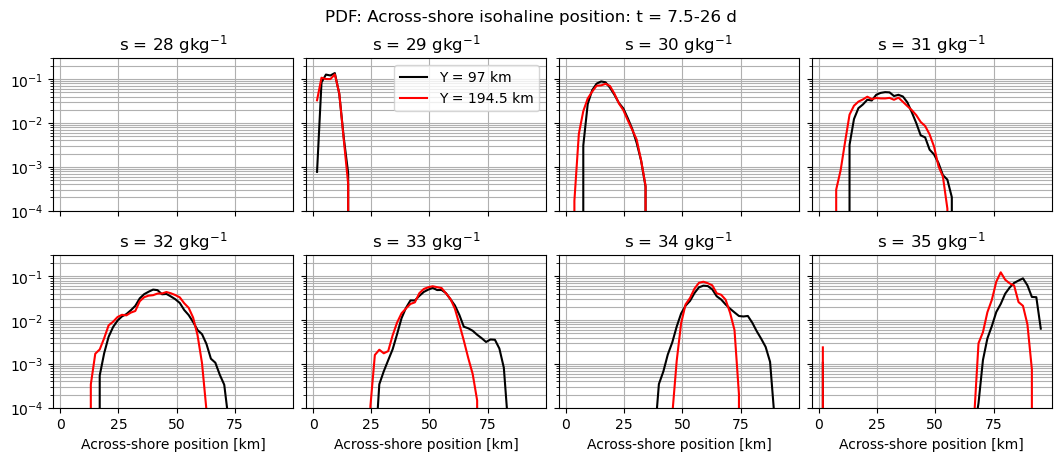

In [14]:
nrows = 2; ncols = 4
fig, ax = plt.subplots(nrows,ncols, figsize = ((7/2)*3,4.5), sharey = True, sharex = True, constrained_layout = True, dpi = 100)

ax[0,1].semilogy(bins_u/1000, pdfu[1], c = 'k', label = 'Y = 97 km')
ax[0,1].semilogy(bins_u/1000, pdfu_2y[1], c = 'r', label = 'Y = 194.5 km')
ax[0,1].legend()

ax[0,2].semilogy(bins_u/1000, pdfu[2], c = 'k', label = 'Y = 97 km')
ax[0,2].semilogy(bins_u/1000, pdfu_2y[2], c = 'r', label = 'Y = 194.5 km')

ax[0,3].semilogy(bins_u/1000, pdfu[3], c = 'k', label = 'Y = 97 km')
ax[0,3].semilogy(bins_u/1000, pdfu_2y[3], c = 'r', label = 'Y = 194.5 km')

ax[1,0].semilogy(bins_u/1000, pdfu[4], c = 'k', label = 'Y = 97 km')
ax[1,0].semilogy(bins_u/1000, pdfu_2y[4], c = 'r', label = 'Y = 194.5 km')

ax[1,1].semilogy(bins_u/1000, pdfu[5], c = 'k', label = 'Y = 97 km')
ax[1,1].semilogy(bins_u/1000, pdfu_2y[5], c = 'r', label = 'Y = 194.5 km')

ax[1,2].semilogy(bins_u/1000, pdfu[6], c = 'k', label = 'Y = 97 km')
ax[1,2].semilogy(bins_u/1000, pdfu_2y[6], c = 'r', label = 'Y = 194.5 km')

ax[1,3].semilogy(bins_u/1000, pdfu[7], c = 'k', label = 'Y = 97 km')
ax[1,3].semilogy(bins_u/1000, pdfu_2y[7], c = 'r', label = 'Y = 194.5 km')

for i in range(2):
    for j in range(4):
        ax[i,j].grid(which = 'both')
        ax[1,j].set_xlabel('Across-shore position [km]')
        ax[i,j].set_ylim(1e-4, 3e-1)
for j in range(4):
    ax[0,j].set_title('s = ' + str(28+j) + ' gkg$^{-1}$')
    ax[1,j].set_title('s = ' + str(32+j) + ' gkg$^{-1}$')

fig.suptitle('PDF: Across-shore isohaline position: t = 7.5-26 d')
plt.savefig('isohaline_pdfs_u3hc4.jpg', dpi = 500)

### Now we want to do a sensitivity study. Try turning this into a script where the only thing that changes is length of time used for the analysis

In [15]:
print(ds[0].ocean_time[380-44])
print(380-44-156)

<xarray.DataArray 'ocean_time' ()>
array(cftime.DatetimeProlepticGregorian(1, 1, 15, 0, 30, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    ocean_time  object 0001-01-15 00:30:00
Attributes:
    long_name:      averaged time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time
180


In [17]:
tlen = 180

#Run the function for each scheme
yhistu = []
yhistu_2y = [] #Double across-shore distance
for j in range(len(isovalue)):
    yraw_u, yhist_u, bins_u = isohaline_pos(ds[0], tlen, etaslice, xislice, isovalue[j], nbins) #U3HC4
    yraw_u2, yhist_u2, bins_u2 = isohaline_pos(ds[1], tlen, etaslice, xislice, isovalue[j], nbins) #U3HC4
    
    yhistu.append(yhist_u)
    yhistu_2y.append(yhist_u2)
    
pdfu = []
cdfu = []
pdfu_2y = []
cdfu_2y = []
for j in range(len(isovalue)):
    pdf_u, cdf_u = hist_to_pdf(np.array(yhistu[j]), bins_u)
    pdf_u2, cdf_u2 = hist_to_pdf(np.array(yhistu_2y[j]), bins_u2)
    
    pdfu.append(pdf_u)
    cdfu.append(cdf_u)
    
    pdfu_2y.append(pdf_u2)
    cdfu_2y.append(cdf_u2)

Text(0.5, 0.98, 'PDF: Across-shore isohaline position: t = 7.5-15 d')

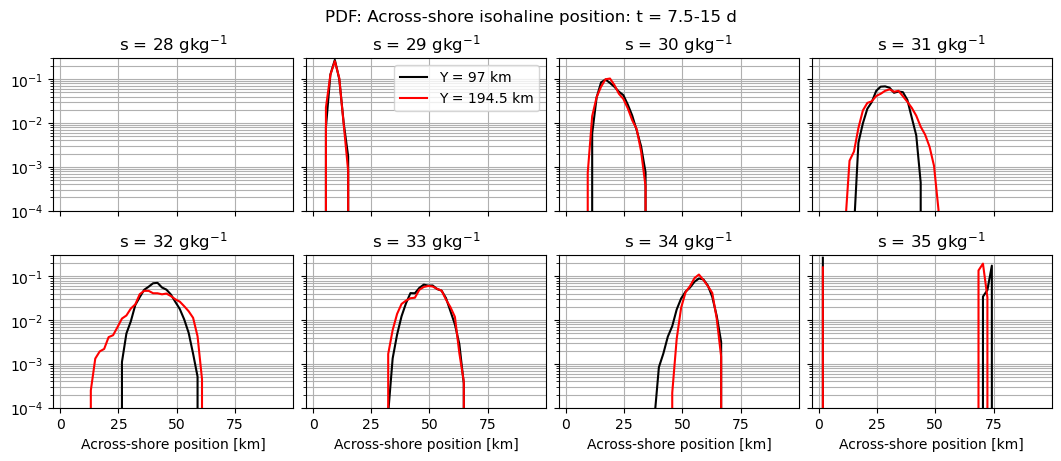

In [18]:
nrows = 2; ncols = 4
fig, ax = plt.subplots(nrows,ncols, figsize = ((7/2)*3,4.5), sharey = True, sharex = True, constrained_layout = True, dpi = 100)

ax[0,1].semilogy(bins_u/1000, pdfu[1], c = 'k', label = 'Y = 97 km')
ax[0,1].semilogy(bins_u/1000, pdfu_2y[1], c = 'r', label = 'Y = 194.5 km')
ax[0,1].legend()

ax[0,2].semilogy(bins_u/1000, pdfu[2], c = 'k', label = 'Y = 97 km')
ax[0,2].semilogy(bins_u/1000, pdfu_2y[2], c = 'r', label = 'Y = 194.5 km')

ax[0,3].semilogy(bins_u/1000, pdfu[3], c = 'k', label = 'Y = 97 km')
ax[0,3].semilogy(bins_u/1000, pdfu_2y[3], c = 'r', label = 'Y = 194.5 km')

ax[1,0].semilogy(bins_u/1000, pdfu[4], c = 'k', label = 'Y = 97 km')
ax[1,0].semilogy(bins_u/1000, pdfu_2y[4], c = 'r', label = 'Y = 194.5 km')

ax[1,1].semilogy(bins_u/1000, pdfu[5], c = 'k', label = 'Y = 97 km')
ax[1,1].semilogy(bins_u/1000, pdfu_2y[5], c = 'r', label = 'Y = 194.5 km')

ax[1,2].semilogy(bins_u/1000, pdfu[6], c = 'k', label = 'Y = 97 km')
ax[1,2].semilogy(bins_u/1000, pdfu_2y[6], c = 'r', label = 'Y = 194.5 km')

ax[1,3].semilogy(bins_u/1000, pdfu[7], c = 'k', label = 'Y = 97 km')
ax[1,3].semilogy(bins_u/1000, pdfu_2y[7], c = 'r', label = 'Y = 194.5 km')

for i in range(2):
    for j in range(4):
        ax[i,j].grid(which = 'both')
        ax[1,j].set_xlabel('Across-shore position [km]')
        ax[i,j].set_ylim(1e-4, 3e-1)
for j in range(4):
    ax[0,j].set_title('s = ' + str(28+j) + ' gkg$^{-1}$')
    ax[1,j].set_title('s = ' + str(32+j) + ' gkg$^{-1}$')

fig.suptitle('PDF: Across-shore isohaline position: t = 7.5-15 d')
# plt.savefig('isohaline_pdfs_u3hc4.jpg', dpi = 500)

### Even at 15 days, some of he higher salinity classes are quite different. In conclusion, we need to rerun MPDATA and HSIMT for the Y = 194.5 km case 